## 1. Import Libraries

Import all required Python libraries for data processing, machine learning, visualization, and neural network modeling.

# Transport Mode Choice Neural Network Analysis

This notebook builds and analyzes a neural network model for predicting transport mode choices (PT, Drive, Cycle, Walk) based on trip characteristics, individual attributes, and travel times/costs.

In [2]:
# Standard Python libraries
import pandas as pd
from sklearn.model_selection import train_test_split

## 2. Data Loading

Load the transport dataset containing trip records with mode choices and attributes.

In [3]:
# Additional imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import export_graphviz

In [4]:
df = pd.read_csv(r"C:\Users\crist\Documents\Cristian\Advanced Data Analysis Code\Data\dataset.csv")

## 3. Feature Engineering

Create new features to capture important relationships and patterns in the data:
- **PT modal shares**: Proportion of bus vs rail in public transport
- **PT penalty index**: Composite measure of PT friction (walking, waiting, interchanges)
- **Friction variables**: Binary indicators for interchange patterns and PT mode combinations
- **Household size**: Number of people in the household

In [5]:
# Calculate PT modal shares (to avoid division by zero, add small epsilon)
df['pt_share_bus'] = df['dur_pt_bus'] / (df['dur_pt_bus'] + df['dur_pt_rail'] + 1e-6)
df['pt_share_rail'] = 1 - df['pt_share_bus']
# Create the PT penalty index
df['pt_penalty_index'] = (df['dur_pt_access'] + df['dur_pt_int_walking'] +  # total walking time
                         df['dur_pt_int_waiting'] +  # total waiting time
                         df['pt_n_interchanges'] * 0.1)  # interchange penalty

In [6]:
# Creating Friction variables
df['has_interchange'] = (df['pt_n_interchanges'] > 0).astype(int)
df['multi_interchange'] = (df['pt_n_interchanges'] >= 2).astype(int)
df['is_bus_only'] = ((df['dur_pt_rail'] == 0) & (df['dur_pt_bus'] > 0)).astype(int)
df['is_rail_only'] = ((df['dur_pt_bus'] == 0) & (df['dur_pt_rail'] > 0)).astype(int)
df['is_mixed_pt'] = ((df['dur_pt_bus'] > 0) & (df['dur_pt_rail'] > 0)).astype(int)

In [7]:
# Create a new variable for total in-vehicle public transport time
df['pt_in_vehicle'] = df['dur_pt_bus'] + df['dur_pt_rail']

In [8]:
# Calculate max person_n for each household_id and add as n_household column
household_max = df.groupby('household_id')['person_n'].max().reset_index()
household_max.columns = ['household_id', 'n_household']

# Merge back to the main dataset
df = df.merge(household_max, on='household_id', how='left')

## 4. Data Preparation

Prepare the data for modeling:
- Select relevant features
- Encode the target variable (travel_mode)
- One-hot encode categorical variables (purpose)
- Split into training and test sets

In [9]:
# Select specific columns from the data
# selected_data = df[['travel_mode', 'purpose', 'travel_month', 'travel_date', 'day_of_week', 'start_time_linear', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total', 'driving_traffic_percent', 'pt_n_interchanges', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting', 'car_ownership', 'female', 'driving_license', 'age', n_household']]
selected_data = df[['travel_mode', 'purpose', 'travel_month', 'travel_date', 'day_of_week', 'start_time_linear', 'distance', 'dur_walking', 'dur_cycling', 'dur_pt_total', 'dur_driving', 'cost_transit', 'cost_driving_total', 'driving_traffic_percent', 'dur_pt_rail', 'dur_pt_bus', 'dur_pt_access', 'dur_pt_int_walking', 'dur_pt_int_waiting', 'car_ownership', 'female', 'driving_license', 'age', 'pt_share_bus', 'pt_share_rail', 'pt_penalty_index', 'has_interchange', 'multi_interchange', 'is_bus_only', 'is_rail_only', 'is_mixed_pt', 'pt_in_vehicle', 'n_household']]


In [10]:
# Check actual values first:
print(selected_data['travel_mode'].unique())
# Clean whitespace before mapping:
selected_data['travel_mode'] = selected_data['travel_mode'].str.strip().str.lower()

['drive' 'pt' 'walk' 'cycle']


C:\Users\crist\AppData\Local\Temp\ipykernel_3012\852694133.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['travel_mode'] = selected_data['travel_mode'].str.strip().str.lower()


In [11]:
# Create mapping dictionary for travel modes
mode_mapping = {'pt': 0, 'drive': 1, 'cycle': 2, 'walk': 3}

# Convert travel_mode to integers using the mapping
selected_data['travel_mode'] = selected_data['travel_mode'].map(mode_mapping)

C:\Users\crist\AppData\Local\Temp\ipykernel_3012\455452875.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data['travel_mode'] = selected_data['travel_mode'].map(mode_mapping)


In [12]:
# One-hot encode the 'purpose' column
purpose_dummies = pd.get_dummies(selected_data['purpose'], prefix='purpose')

# Convert boolean to integer (0/1)
purpose_dummies = purpose_dummies.astype(int)

# Concatenate the dummy variables with the original dataframe
selected_data = pd.concat([selected_data, purpose_dummies], axis=1)

# Drop the original 'purpose' column
selected_data = selected_data.drop('purpose', axis=1)

In [13]:
# extract power and weight as data matrix X
X = selected_data.drop(['travel_mode'], axis=1).values
# extract origin as target vector y
y = selected_data['travel_mode'].values

In [14]:
# Calculate the size of matrix X
print(f"Shape of X: {X.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Total size (elements): {X.size}")


Shape of X: (81086, 36)
Number of samples: 81086
Number of features: 36
Total size (elements): 2919096


In [15]:
# Check the shape and contents of y
print(f"Shape of y: {y.shape}")
print(f"Value counts in y:")
unique, counts = pd.Series(y).value_counts().sort_index().index, pd.Series(y).value_counts().sort_index().values
for val, count in zip(unique, counts):
    print(f"  {val}: {count}")

Shape of y: (81086,)
Value counts in y:
  0: 28605
  1: 35808
  2: 2405
  3: 14268


In [17]:
# split into training data (80%) and test data (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 5. Data Preprocessing for Neural Networks

Scale features and convert target to one-hot encoding for neural network training.

In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical

# 1) Scale X (continuous + dummies together is fine)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

num_classes = 4
y_train_oh = to_categorical(y_train, num_classes=num_classes)
y_test_oh  = to_categorical(y_test,  num_classes=num_classes)

## 6. Neural Network Model Building 

Build a deep neural network model for transport mode classification using:
- Swish activation function
- Batch normalization
- Dropout regularization
- Softmax output layer for multi-class classification

## Neural Network Model Building (Accuracy Metric)

In [106]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

n_features = X_train_scaled.shape[1]

#initialize weigths
initializer = tf.keras.initializers.HeNormal()

def build_mode_choice_model():
    model = tf.keras.Sequential()
    
    # Hidden layers (tweak sizes if you like)
    model.add(Dense(64, input_shape=(n_features,),
                    activation='swish', kernel_initializer=initializer))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='swish', kernel_initializer=initializer))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    # Compile with categorical cross-entropy
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        # metrics=['categorical_crossentropy']
    )
    return model

model = build_mode_choice_model()
model.summary()


c:\Users\crist\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_156 (Dense)               │ (None, 64)             │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_114         │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_115         │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_158 (Dense)               │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,964 (19.39 KB)

 Trainable params: 4,772 (18.64 KB)

 Non-trainable params: 192 (768.00 B)

## 7. Model Training

Train the neural network model with:
- Categorical cross-entropy loss
- Adam optimizer
- Early stopping to prevent overfitting
- Validation split for monitoring performance

In [ ]:
# Define early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_scaled, y_train_oh,
    epochs=60,
    batch_size=200,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Test performance
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_oh, verbose=0)
print(f"Test accuracy: {test_acc:.3f}")


Epoch 1/60


## 8. Training Visualization

Visualize training progress through loss curves to check for convergence and overfitting.

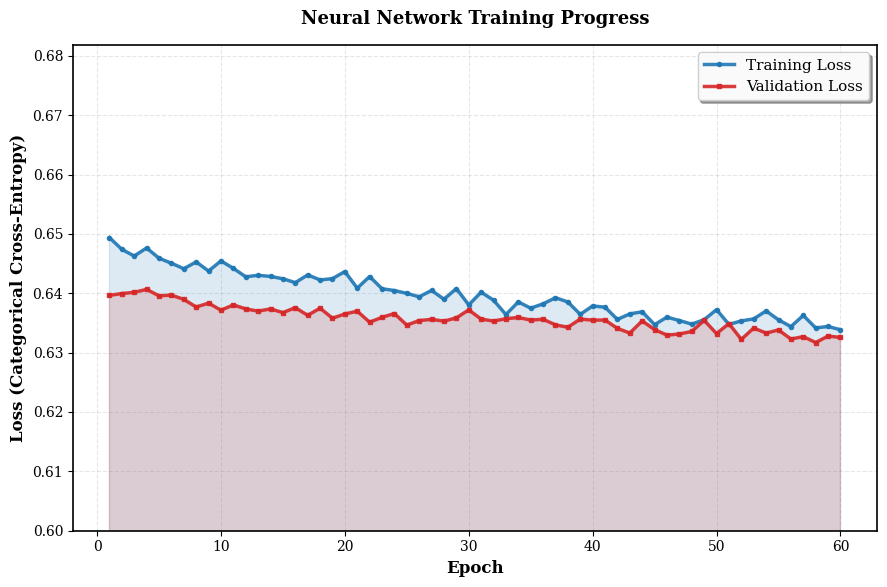

In [101]:
# Show training and validation loss after each epoch (Academic formatting)
loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt

# Set publication-quality style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

fig, ax = plt.subplots(figsize=(9, 6), dpi=100)

# Plot with semi-transparent fill
epochs = range(1, len(loss) + 1)
ax.plot(epochs, loss, color='#1f77b4', linewidth=2.5, label='Training Loss', marker='o', markersize=3, alpha=0.9)
ax.plot(epochs, val_loss, color='#d62728', linewidth=2.5, label='Validation Loss', marker='s', markersize=3, alpha=0.9)
ax.fill_between(epochs, loss, alpha=0.15, color='#1f77b4')
ax.fill_between(epochs, val_loss, alpha=0.15, color='#d62728')

# Professional labels and title
ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Loss (Categorical Cross-Entropy)', fontsize=12, fontweight='bold')
ax.set_title('Neural Network Training Progress', fontsize=13, fontweight='bold', pad=15)

# Enhanced grid
ax.grid(True, linestyle='--', alpha=0.3, linewidth=0.8)
ax.set_axisbelow(True)

# Set y-axis minimum
ax.set_ylim(bottom=0.6)

# Legend
ax.legend(fontsize=11, loc='upper right', frameon=True, shadow=True, framealpha=0.95)

# Tight layout
plt.tight_layout()
plt.show()

## 9. Architecture + Activation Function Search

Comprehensive search combining different architectures with various activation functions (swish, relu, tanh).

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import time
import pandas as pd
import matplotlib.pyplot as plt

n_features = X_train_scaled.shape[1]

# --- 1) Base architectures (just layer widths) ---
base_architectures = [
    {
        'name': 'Small',
        'layers': [64, 32],
        'dropouts': [0.2, 0.2],
    },
    {
        'name': 'Medium',
        'layers': [128, 64, 32, 16],
        'dropouts': [0.2, 0.2, 0.2, 0.2],
    },
    {
        'name': 'Large',
        'layers': [256, 128, 64, 32],
        'dropouts': [0.3, 0.3, 0.2, 0.2],
    },
    {
        'name': 'Deep',
        'layers': [128, 128, 64, 64, 32],
        'dropouts': [0.2, 0.2, 0.2, 0.2, 0.2],
    },
    {
        'name': 'Wide',
        'layers': [512, 256],
        'dropouts': [0.3, 0.3],
    },
]

# --- 2) Activation functions to try ---
# swish is available as string in TF 2.10+, otherwise use tf.nn.swish
activation_space = ["swish", "relu", "tanh"]


In [64]:
from tensorflow.keras.initializers import HeNormal, GlorotUniform

def get_initializer(activation: str):
    activation = activation.lower()
    if activation in ["relu", "swish"]:
        return HeNormal()
    elif activation in ["tanh"]:
        return GlorotUniform()
    else:
        return GlorotUniform()


In [65]:
architecture_results = []

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

for base in base_architectures:
    for act in activation_space:
        arch_name = f"{base['name']} ({'-'.join(map(str, base['layers']))}) - {act}"
        print(f"\n{'='*60}")
        print(f"Testing: {arch_name}")
        print(f"{'='*60}")

        # Build model
        test_model = Sequential()
        initializer = get_initializer(act)

        # First layer with input_shape
        test_model.add(
            Dense(
                base['layers'][0],
                activation=act,
                kernel_initializer=initializer,
                input_shape=(n_features,)
            )
        )
        test_model.add(BatchNormalization())
        test_model.add(Dropout(base['dropouts'][0]))

        # Hidden layers
        for units, do_rate in zip(base['layers'][1:], base['dropouts'][1:]):
            test_model.add(
                Dense(
                    units,
                    activation=act,
                    kernel_initializer=initializer
                )
            )
            test_model.add(BatchNormalization())
            test_model.add(Dropout(do_rate))

        # Output layer
        test_model.add(Dense(4, activation='softmax'))

        # Compile
        test_model.compile(
            optimizer=Adam(learning_rate=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        total_params = test_model.count_params()

        # Train
        start_time = time.time()
        history_test = test_model.fit(
            X_train_scaled, y_train_oh,
            epochs=30,
            batch_size=200,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )
        train_time = time.time() - start_time

        # Evaluate
        test_loss_arch, test_acc_arch = test_model.evaluate(
            X_test_scaled, y_test_oh,
            verbose=0
        )

        result = {
            'architecture': arch_name,
            'base_arch': base['name'],
            'activation': act,
            'params': total_params,
            'train_time': train_time,
            'epochs_trained': len(history_test.history['loss']),
            'final_train_loss': history_test.history['loss'][-1],
            'final_val_loss': history_test.history['val_loss'][-1],
            'test_nll': test_acc_arch,
            'test_loss': test_loss_arch,
        }
        architecture_results.append(result)

        print(f"Parameters: {total_params:,}")
        print(f"Epochs trained: {len(history_test.history['loss'])}")
        print(f"Training time: {train_time:.2f}s")
        print(f"Test NLL: {test_acc_arch:.4f}")
        print(f"Test loss: {test_loss_arch:.4f}")



Testing: Small (64-32) - swish


c:\Users\crist\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Parameters: 4,964
Epochs trained: 30
Training time: 102.19s
Test NLL: 0.7494
Test loss: 0.6431

Testing: Small (64-32) - relu
Parameters: 4,964
Epochs trained: 10
Training time: 40.76s
Test NLL: 0.7201
Test loss: 0.7394

Testing: Small (64-32) - tanh
Parameters: 4,964
Epochs trained: 10
Training time: 45.81s
Test NLL: 0.7225
Test loss: 0.7374

Testing: Medium (128-64-32-16) - swish
Parameters: 16,628
Epochs trained: 10
Training time: 83.09s
Test NLL: 0.7196
Test loss: 0.7666

Testing: Medium (128-64-32-16) - relu
Parameters: 16,628
Epochs trained: 10
Training time: 59.61s
Test NLL: 0.7133
Test loss: 0.7701

Testing: Medium (128-64-32-16) - tanh
Parameters: 16,628
Epochs trained: 10
Training time: 73.85s
Test NLL: 0.7174
Test loss: 0.7622

Testing: Large (256-128-64-32) - swish
Parameters: 54,756
Epochs trained: 10
Training time: 97.75s
Test NLL: 0.7309
Test loss: 0.7216

Testing: Large (256-128-64-32) - relu
Parameters: 54,756
Epochs trained: 10
Training time: 110.35s
Test NLL: 0.7217


In [87]:
results_df = pd.DataFrame(architecture_results)
results_df = results_df.sort_values('test_loss', ascending=True)

print("\n" + "="*60)
print("ARCHITECTURE + ACTIVATION SEARCH RESULTS (sorted by test loss)")
print("="*60)
print(results_df.to_string(index=False))

print(f"\nBest configuration: {results_df.iloc[0]['architecture']}")
print(f"Best test accuracy: {results_df.iloc[0]['test_loss']:.4f}")



ARCHITECTURE + ACTIVATION SEARCH RESULTS (sorted by test loss)
                   architecture base_arch activation  params  train_time  epochs_trained  final_train_loss  final_val_loss  test_nll  test_loss
         Wide (512-256) - swish      Wide      swish  154372  319.051025              30          0.607347        0.630826  0.751881   0.634966
          Small (64-32) - swish     Small      swish    4964  102.186474              30          0.654710        0.643366  0.749414   0.643127
          Wide (512-256) - relu      Wide       relu  154372  110.584610              10          0.652819        0.650088  0.736774   0.681223
          Wide (512-256) - tanh      Wide       tanh  154372  120.626977              10          0.670857        0.658333  0.723517   0.702471
  Large (256-128-64-32) - swish     Large      swish   54756   97.749300              10          0.680671        0.652198  0.730855   0.721628
   Large (256-128-64-32) - relu     Large       relu   54756  110.348999

## 9. Model Evaluation

Evaluate model performance using:
- Prediction accuracy
- Confusion matrix
- Per-class accuracy (recall)
- F1 scores
- Log-likelihood
- Classification report

In [103]:
# Probabilities for each mode
probs_test = model.predict(X_test_scaled)   # shape (n_test, 4)

# Predicted class index (0..3)
y_pred_idx = np.argmax(probs_test, axis=1)

# Map back to original labels (Car/PT/Cycle/Walk)
# Map back to original labels (Car/PT/Cycle/Walk)
mode_labels = {0: 'pt', 1: 'drive', 2: 'cycle', 3: 'walk'}
y_pred_labels = [mode_labels[idx] for idx in y_pred_idx]

# Example: first 10
for i in range(20):
    print(f"True: {y_test[i]}, Pred: {y_pred_labels[i]}, Probs: {probs_test[i]}")


507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
True: 1, Pred: pt, Probs: [7.8490531e-01 2.1439773e-01 1.6516120e-04 5.3181750e-04]
True: 0, Pred: pt, Probs: [0.7800912  0.08909962 0.06007464 0.07073451]
True: 0, Pred: pt, Probs: [0.84066236 0.03926132 0.00293907 0.11713728]
True: 3, Pred: walk, Probs: [0.13154902 0.0154752  0.08347998 0.76949584]
True: 0, Pred: pt, Probs: [0.8475798  0.06650776 0.01832802 0.06758441]
True: 3, Pred: walk, Probs: [0.11901294 0.02581722 0.02279358 0.8323762 ]
True: 3, Pred: walk, Probs: [0.01342116 0.0083251  0.00625758 0.9719962 ]
True: 1, Pred: drive, Probs: [0.04969634 0.87101364 0.0532494  0.02604055]
True: 0, Pred: pt, Probs: [0.8425225  0.10933948 0.00744129 0.04069666]
True: 1, Pred: drive, Probs: [0.21182895 0.72225    0.04592932 0.01999177]
True: 1, Pred: pt, Probs: [0.6553137  0.22245322 0.11830896 0.00392416]
True: 1, Pred: drive, Probs: [0.08879069 0.84095395 0.01436936 0.05588601]
True: 0, Pred: drive, Probs: [0.2104299  0.7525152  0.01596635 0.021

In [104]:
# compute and print accuracy score
acc = accuracy_score(y_test, y_pred_idx)
print(f"Accuracy (sklearn): {acc:.6f}")
print(f"Neural network reported test_acc: {test_acc:.6f}")

Accuracy (sklearn): 0.751202
Neural network reported test_acc: 0.751202



Prediction accuracy (weighted if applicable): 0.751


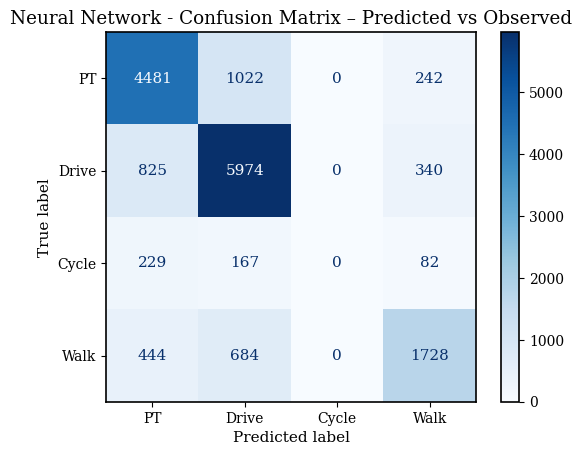


Per-class Accuracy (Recall):
PT: 0.7800 (4481.0/5745.0)
Drive: 0.8368 (5974.0/7139.0)
Cycle: 0.0000 (0.0/478.0)
Walk: 0.6050 (1728.0/2856.0)

Weighted log-likelihood: -10287.900
Average weighted log-likelihood per obs: -0.6344

F1 SCORES

Per-class F1 Scores:
  PT      : 0.7644
  Drive   : 0.7973
  Cycle   : 0.0000
  Walk    : 0.6585

Macro Average F1 Score: 0.5551

CLASSIFICATION REPORT
              precision    recall  f1-score   support

          PT       0.75      0.78      0.76      5745
       Drive       0.76      0.84      0.80      7139
       Cycle       0.00      0.00      0.00       478
        Walk       0.72      0.61      0.66      2856

    accuracy                           0.75     16218
   macro avg       0.56      0.56      0.56     16218
weighted avg       0.73      0.75      0.74     16218



c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\crist\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [105]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predicted classes
y_pred_idx = np.argmax(probs_test, axis=1)

# ---------------------------------------------------------------
# Accuracy and confusion matrix (weighted)
# ---------------------------------------------------------------
# For neural network, we'll use uniform weights (no weighting)
# If you have weights, define w here. Otherwise w=1 for all observations
w = np.ones(len(y_test))
w_sum = w.sum()

acc_weighted = (w * (y_pred_idx == y_test)).sum() / w_sum
print(f"\nPrediction accuracy (weighted if applicable): {acc_weighted:.3f}")

cm = confusion_matrix(y_test, y_pred_idx, labels=[0, 1, 2, 3], sample_weight=w)
disp = ConfusionMatrixDisplay(cm, display_labels=['PT', 'Drive', 'Cycle', 'Walk'])
disp.plot(cmap='Blues', values_format='.0f')
plt.title("Neural Network - Confusion Matrix – Predicted vs Observed")
plt.show()

# Calculate per-class accuracy (recall)
print("\nPer-class Accuracy (Recall):")
for i, mode in enumerate(['PT', 'Drive', 'Cycle', 'Walk']):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"{mode}: {class_accuracy:.4f} ({cm[i, i]}/{cm[i, :].sum()})")

# ---------------------------------------------------------------
# Weighted log-likelihood
# ---------------------------------------------------------------
# Get probability for the chosen class for each observation
prob_chosen = probs_test[np.arange(len(y_test)), y_test]
prob_chosen = np.clip(prob_chosen, 1e-300, 1)
LL = np.sum(w * np.log(prob_chosen))
avg_LL = LL / w_sum
print(f"\nWeighted log-likelihood: {LL:.3f}")
print(f"Average weighted log-likelihood per obs: {avg_LL:.4f}")

# ---------------------------------------------------------------
# F1 Scores (Per-class and Macro Average)
# ---------------------------------------------------------------
from sklearn.metrics import f1_score, classification_report

target_names = ['PT', 'Drive', 'Cycle', 'Walk']

# Calculate per-class F1 scores
f1_per_class = f1_score(y_test, y_pred_idx, average=None, labels=[0, 1, 2, 3])

# Calculate macro average F1 score
macro_f1 = f1_score(y_test, y_pred_idx, average='macro')

print("\n" + "="*60)
print("F1 SCORES")
print("="*60)
print("\nPer-class F1 Scores:")
for i, (mode, f1) in enumerate(zip(target_names, f1_per_class)):
    print(f"  {mode:8s}: {f1:.4f}")

print(f"\nMacro Average F1 Score: {macro_f1:.4f}")

# Full classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_pred_idx, target_names=target_names))

## 10. Market Share Analysis

Compare predicted market shares (based on average probabilities across the test set) with observed market shares to validate model alignment with real-world distributions. This analysis shows whether the neural network predictions match actual mode choice proportions.


507/507 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
True shares:
 0    0.354236
1    0.440190
2    0.029473
3    0.176101
Name: proportion, dtype: float64

Predicted shares (probability mean):
 0    0.361047
1    0.435672
2    0.028826
3    0.174454
dtype: float32


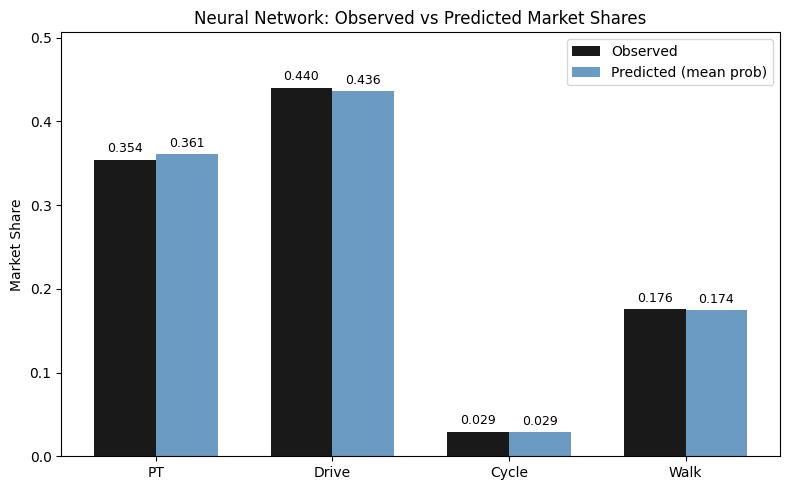

In [95]:
# Compare Neural Network predicted market shares with observed market shares
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get predictions from the NN model
proba = model.predict(X_test_scaled)
pred_shares = pd.Series(proba.mean(axis=0), index=range(num_classes))
true_shares = pd.Series(y_test).value_counts(normalize=True).sort_index()

print("True shares:\n", true_shares)
print("\nPredicted shares (probability mean):\n", pred_shares)

# Bar plot: observed vs predicted (mean probability) market shares
class_labels = [target_names[int(c)] for c in range(num_classes)]
observed = true_shares.values
predicted = pred_shares.values

x = np.arange(len(class_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars_obs = ax.bar(x - width/2, observed, width, label='Observed', color='black', alpha=0.9)
bars_pred = ax.bar(x + width/2, predicted, width, label='Predicted (mean prob)', color='steelblue', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.set_ylabel('Market Share')
ax.set_title('Neural Network: Observed vs Predicted Market Shares')
ax.legend()
ax.set_ylim(0, max(observed.max(), predicted.max()) * 1.15)

for bars in (bars_obs, bars_pred):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f'{h:.3f}', xy=(bar.get_x() + bar.get_width() / 2, h),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## 11. Car Cost + Time Scenario Analysis

Simulate the impact of changes in driving cost and time on mode choice predictions using the trained neural network model.

**Scenario Design:**
- **Effect 1 (Cost)**: Increase driving monetary cost by +10%, +20%, +30% (and symmetric -10%, -20%, -30%)
- **Effect 2 (Time)**: Increase driving in-vehicle time by +2%, +5%, +8% (scaled 1:5 with cost changes)
- **Total Scenarios**: 7 combinations (baseline + 3 increases + 3 decreases)

For each scenario:
1. Create modified test dataset with adjusted costs and times
2. Scale the modified features using the fitted scaler
3. Generate NN predictions for all modes
4. Calculate predicted market shares
5. Compare to baseline and identify winners/losers


In [96]:
import pandas as pd
import numpy as np

# COUNTERFACTUAL SCENARIO ANALYSIS
# ==============================================================================
# Approach: For each observation, generate predictions under:
# 1. Baseline (actual scenario) - using current test set
# 2. Counterfactual (policy intervention) - modified costs/times
# Then compare individual-level changes and aggregate to market shares
# ==============================================================================

# Generate baseline predictions using the already-scaled test data
probs_baseline = model.predict(X_test_scaled, verbose=0)
baseline_market_share = probs_baseline.mean(axis=0)

print("="*80)
print("CAR COST + TIME SCENARIO ANALYSIS - NEURAL NETWORK MODEL (COUNTERFACTUAL)")
print("="*80)
print(f"\nTotal test observations: {len(X_test_scaled)}")
print(f"\nBASELINE Market Shares:")
for mode_idx, mode_name in enumerate(target_names):
    print(f"  {mode_name:8s}: {baseline_market_share[mode_idx]:.4f}")

# Define scenario parameters
cost_changes = [0.10, 0.20, 0.30]
time_changes = [0.02, 0.05, 0.08]

scenario_results = {}
scenario_names = [
    'Cost +10%, Time +2%',
    'Cost +20%, Time +5%',
    'Cost +30%, Time +8%'
]

print("\n" + "="*80)
print("COUNTERFACTUAL SCENARIOS")
print("="*80)

# Get feature indices for cost and time
feature_cols = list(selected_data.drop(['travel_mode'], axis=1).columns)
cost_idx = feature_cols.index('cost_driving_total')
time_idx = feature_cols.index('dur_driving')

for scenario_idx, (cost_change, time_change, scenario_name) in enumerate(zip(cost_changes, time_changes, scenario_names)):
    print(f"\n{'='*80}")
    print(f"Scenario {scenario_idx + 1}: {scenario_name}")
    print(f"{'='*80}")
    
    # Create counterfactual data by modifying X_test (unscaled) and rescaling
    X_counterfactual = X_test.copy().astype(float)
    X_counterfactual[:, cost_idx] = X_counterfactual[:, cost_idx] * (1 + cost_change)
    X_counterfactual[:, time_idx] = X_counterfactual[:, time_idx] * (1 + time_change)
    
    # Scale the counterfactual data
    X_counterfactual_scaled = scaler.transform(X_counterfactual)
    
    # Generate counterfactual predictions (same individuals, modified costs/times)
    probs_counterfactual = model.predict(X_counterfactual_scaled, verbose=0)
    
    # Calculate counterfactual market shares (from aggregate of individual predictions)
    counterfactual_market_share = probs_counterfactual.mean(axis=0)
    
    # Store results
    scenario_results[scenario_name] = {
        'baseline_probs': probs_baseline,
        'counterfactual_probs': probs_counterfactual,
        'baseline_share': baseline_market_share,
        'counterfactual_share': counterfactual_market_share,
        'cost_change': cost_change,
        'time_change': time_change
    }
    
    # Individual-level changes (average shift in probability for each mode)
    individual_changes = probs_counterfactual - probs_baseline  # n_obs x 4
    mean_prob_change = individual_changes.mean(axis=0)

# ---------------------------------------------------------------
# Summary Table: Market Shares Across All Scenarios
# ---------------------------------------------------------------
print("\n" + "="*80)
print("SUMMARY TABLE: BASELINE vs COUNTERFACTUAL MARKET SHARES")
print("="*80)

summary_data = []
baseline_row = {
    'Scenario': 'Baseline',
    'PT': f"{baseline_market_share[0]:.4f}",
    'Drive': f"{baseline_market_share[1]:.4f}",
    'Cycle': f"{baseline_market_share[2]:.4f}",
    'Walk': f"{baseline_market_share[3]:.4f}"
}
summary_data.append(baseline_row)

for scenario_name in scenario_names:
    shares = scenario_results[scenario_name]['counterfactual_share']
    summary_data.append({
        'Scenario': scenario_name,
        'PT': f"{shares[0]:.4f}",
        'Drive': f"{shares[1]:.4f}",
        'Cycle': f"{shares[2]:.4f}",
        'Walk': f"{shares[3]:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
# Export summary table to Excel
summary_df.to_excel('counterfactual_scenario_analysis.xlsx', index=False, sheet_name='Market Shares')
print("\n✓ Summary table exported to: counterfactual_scenario_analysis.xlsx")

CAR COST + TIME SCENARIO ANALYSIS - NEURAL NETWORK MODEL (COUNTERFACTUAL)

Total test observations: 16218

BASELINE Market Shares:
  PT      : 0.3610
  Drive   : 0.4357
  Cycle   : 0.0288
  Walk    : 0.1745

COUNTERFACTUAL SCENARIOS

Scenario 1: Cost +10%, Time +2%

Scenario 2: Cost +20%, Time +5%

Scenario 3: Cost +30%, Time +8%

SUMMARY TABLE: BASELINE vs COUNTERFACTUAL MARKET SHARES
           Scenario     PT  Drive  Cycle   Walk
           Baseline 0.3610 0.4357 0.0288 0.1745
Cost +10%, Time +2% 0.3647 0.4318 0.0288 0.1747
Cost +20%, Time +5% 0.3694 0.4268 0.0288 0.1749
Cost +30%, Time +8% 0.3741 0.4220 0.0288 0.1751

✓ Summary table exported to: counterfactual_scenario_analysis.xlsx


## 12. Public Transit Service Improvement Scenario Analysis

Simulate the impact of improved public transit service on mode choice predictions using the trained neural network model.

**Scenario Design:**
- **Effect 1 (Access & Wait Times)**: Reduce PT access and internal waiting times by −10%, −20%, −30%
- **Effect 2 (Transfer Penalty)**: Reduce interchange burden by −10%, −20%, −30%
- **Total Scenarios**: 3 combinations representing progressive PT service improvements

For each scenario:
1. Create modified test dataset with adjusted PT time components
2. Scale the modified features using the fitted scaler
3. Generate NN predictions for all modes
4. Calculate predicted market shares
5. Compare to baseline and identify shifts in modal choice



In [97]:
# ==============================================================================
# SCENARIO 2: PT SERVICE IMPROVEMENT (COUNTERFACTUAL)
# ==============================================================================
# Effect 1 (Time): Reduce PT access and waiting times by −10%, −20%, −30%
# Effect 2 (Transfer Penalty): Reduce interchange burden by −10%, −20%, −30%
# ==============================================================================

print("\n" + "="*80)
print("PUBLIC TRANSIT SERVICE IMPROVEMENT SCENARIOS (COUNTERFACTUAL)")
print("Effect 1: Reduced Access & Wait Times | Effect 2: Reduced Transfer Penalties")
print("="*80)

# Get baseline predictions (already computed)
print(f"\nTotal test observations: {len(X_test_scaled)}")
print(f"\nBASELINE Market Shares (Same as before):")
for mode_idx, mode_name in enumerate(target_names):
    print(f"  {mode_name:8s}: {baseline_market_share[mode_idx]:.4f}")

# Get feature indices for PT features
pt_access_idx = feature_cols.index('dur_pt_access')
pt_wait_idx = feature_cols.index('dur_pt_int_waiting')
pt_penalty_idx = feature_cols.index('pt_penalty_index')

# Define PT scenarios
pt_scenarios = [
    ('PT Access/Wait -10% / Transfer Penalty -10%', -0.10, -0.10),
    ('PT Access/Wait -20% / Transfer Penalty -20%', -0.20, -0.20),
    ('PT Access/Wait -30% / Transfer Penalty -30%', -0.30, -0.30),
]

pt_scenario_results = {}
pt_scenario_names = [name for name, _, _ in pt_scenarios]

print("\n" + "="*80)
print("COUNTERFACTUAL PT SERVICE IMPROVEMENT SCENARIOS")
print("="*80)

for scenario_name, time_reduction, transfer_reduction in pt_scenarios:
    print(f"\n{scenario_name}")
    print("-" * 80)
    
    # Create counterfactual data by modifying X_test (unscaled)
    X_pt_scenario = X_test.copy().astype(float)
    
    # Effect 1: Reduce PT access and waiting times
    X_pt_scenario[:, pt_access_idx] = X_pt_scenario[:, pt_access_idx] * (1 + time_reduction)
    X_pt_scenario[:, pt_wait_idx] = X_pt_scenario[:, pt_wait_idx] * (1 + time_reduction)
    
    # Effect 2: Reduce transfer penalty index
    X_pt_scenario[:, pt_penalty_idx] = X_pt_scenario[:, pt_penalty_idx] * (1 + transfer_reduction)
    
    # Scale the scenario data
    X_pt_scenario_scaled = scaler.transform(X_pt_scenario)
    
    # Generate counterfactual predictions
    probs_pt_scenario = model.predict(X_pt_scenario_scaled, verbose=0)
    
    # Calculate counterfactual market shares
    pt_market_share = probs_pt_scenario.mean(axis=0)
    
    # Store results
    pt_scenario_results[scenario_name] = {
        'baseline_probs': probs_baseline,
        'counterfactual_probs': probs_pt_scenario,
        'baseline_share': baseline_market_share,
        'counterfactual_share': pt_market_share,
        'time_reduction': time_reduction,
        'transfer_reduction': transfer_reduction
    }
    
    # Print counterfactual market shares
    print(f"Counterfactual Market Shares:")
    for mode_idx, mode_name in enumerate(target_names):
        print(f"  {mode_name:8s}: {pt_market_share[mode_idx]:.4f}")

# ---------------------------------------------------------------
# Summary Table: Baseline vs PT Scenarios
# ---------------------------------------------------------------
print("\n" + "="*80)
print("SUMMARY TABLE: BASELINE vs PT SERVICE IMPROVEMENT SCENARIOS")
print("="*80)

pt_summary_data = []
baseline_row = {
    'Scenario': 'Baseline',
    'PT': f"{baseline_market_share[0]:.4f}",
    'Drive': f"{baseline_market_share[1]:.4f}",
    'Cycle': f"{baseline_market_share[2]:.4f}",
    'Walk': f"{baseline_market_share[3]:.4f}"
}
pt_summary_data.append(baseline_row)

for scenario_name in pt_scenario_names:
    shares = pt_scenario_results[scenario_name]['counterfactual_share']
    pt_summary_data.append({
        'Scenario': scenario_name,
        'PT': f"{shares[0]:.4f}",
        'Drive': f"{shares[1]:.4f}",
        'Cycle': f"{shares[2]:.4f}",
        'Walk': f"{shares[3]:.4f}"
    })

pt_summary_df = pd.DataFrame(pt_summary_data)
print(pt_summary_df.to_string(index=False))

# Export PT scenario summary table to Excel
pt_summary_df.to_excel('pt_service_improvement_scenarios.xlsx', index=False, sheet_name='Market Shares')
print("\n✓ PT scenario summary table exported to: pt_service_improvement_scenarios.xlsx")


PUBLIC TRANSIT SERVICE IMPROVEMENT SCENARIOS (COUNTERFACTUAL)
Effect 1: Reduced Access & Wait Times | Effect 2: Reduced Transfer Penalties

Total test observations: 16218

BASELINE Market Shares (Same as before):
  PT      : 0.3610
  Drive   : 0.4357
  Cycle   : 0.0288
  Walk    : 0.1745

COUNTERFACTUAL PT SERVICE IMPROVEMENT SCENARIOS

PT Access/Wait -10% / Transfer Penalty -10%
--------------------------------------------------------------------------------
Counterfactual Market Shares:
  PT      : 0.3730
  Drive   : 0.4270
  Cycle   : 0.0275
  Walk    : 0.1725

PT Access/Wait -20% / Transfer Penalty -20%
--------------------------------------------------------------------------------
Counterfactual Market Shares:
  PT      : 0.3853
  Drive   : 0.4180
  Cycle   : 0.0262
  Walk    : 0.1705

PT Access/Wait -30% / Transfer Penalty -30%
--------------------------------------------------------------------------------
Counterfactual Market Shares:
  PT      : 0.3978
  Drive   : 0.4088
  C

## 13. SHAP Analysis for Model Interpretability

Use SHAP (SHapley Additive exPlanations) to understand feature importance and model predictions:
- Compute SHAP values using GradientExplainer
- Analyze feature contributions to each transport mode choice

In [ ]:
import shap
import numpy as np

sample_size = 1000  # Use a sample for faster computation
sample_indices = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
X_test_sample = X_test_scaled[sample_indices]
X_test_sample_orig = X_test[sample_indices]
# Use 200 samples from training data as background

# Use GradientExplainer instead - more stable for neural networks
print("Creating SHAP explainer with GradientExplainer...")

# Use a smaller background dataset for efficiency
explainer = shap.GradientExplainer(model, X_train_scaled)

# Compute SHAP values for test samples
print("Computing SHAP values...")
shap_values = explainer.shap_values(X_test_sample)

# shap_values is a list with one array per output class
print(f"\nSHAP values computed for {len(shap_values)} classes")
print(f"Shape per class: {shap_values[0].shape}")
print(f"Sample ranges per class:")
for i, mode_name in mode_labels.items():
    print(f"  {mode_name}: [{np.min(shap_values[i]):.4f}, {np.max(shap_values[i]):.4f}]")


Creating SHAP explainer with GradientExplainer...
Computing SHAP values...


c:\Users\crist\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1000, 36))']
  warnings.warn(msg)
c:\Users\crist\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 36))']
  warnings.warn(msg)
c:\Users\crist\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 36))']
  warnings.warn(msg)



SHAP values computed for 1000 classes
Shape per class: (36, 4)
Sample ranges per class:
  pt: [-0.2162, 0.2868]
  drive: [-0.2468, 0.2496]
  cycle: [-0.1967, 0.1563]
  walk: [-0.1629, 0.2213]


## 14. SHAP Visualization

Create visual representations of SHAP values:
- Summary plots for each transport mode
- Feature importance rankings
- Local explanations for individual predictions

C:\Users\crist\AppData\Local\Temp\ipykernel_20856\206974303.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


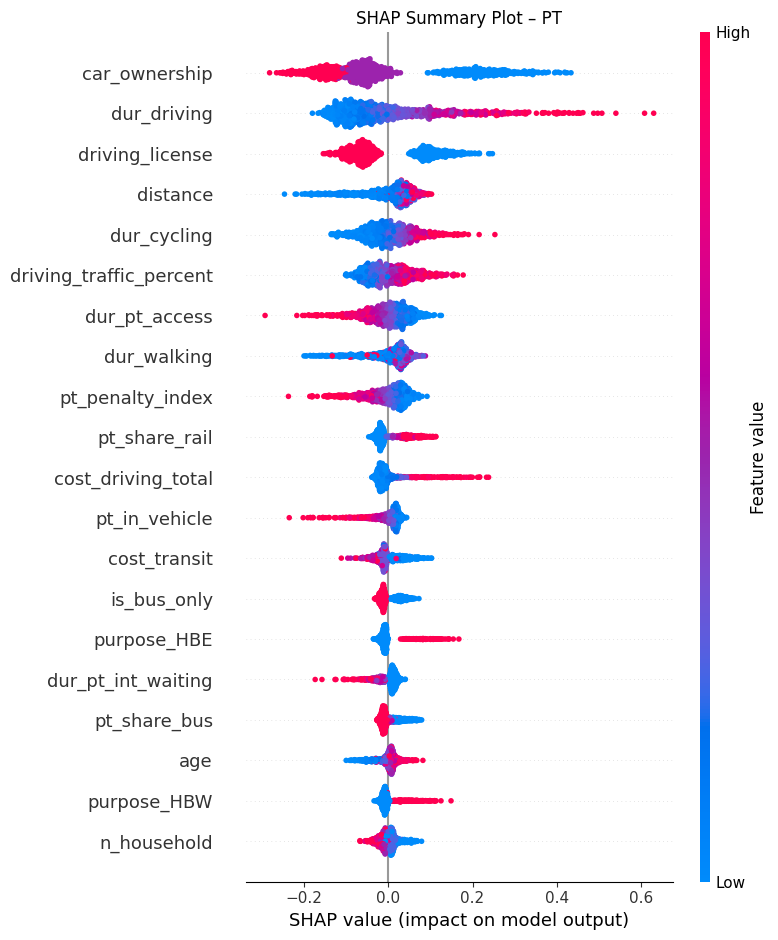

C:\Users\crist\AppData\Local\Temp\ipykernel_20856\206974303.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


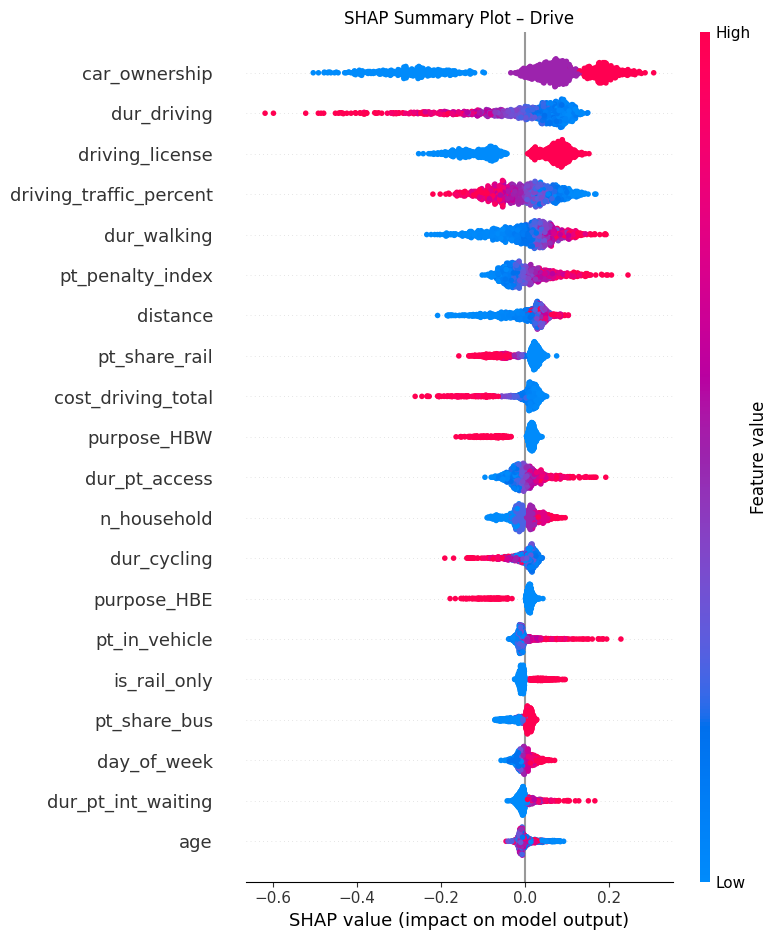

C:\Users\crist\AppData\Local\Temp\ipykernel_20856\206974303.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


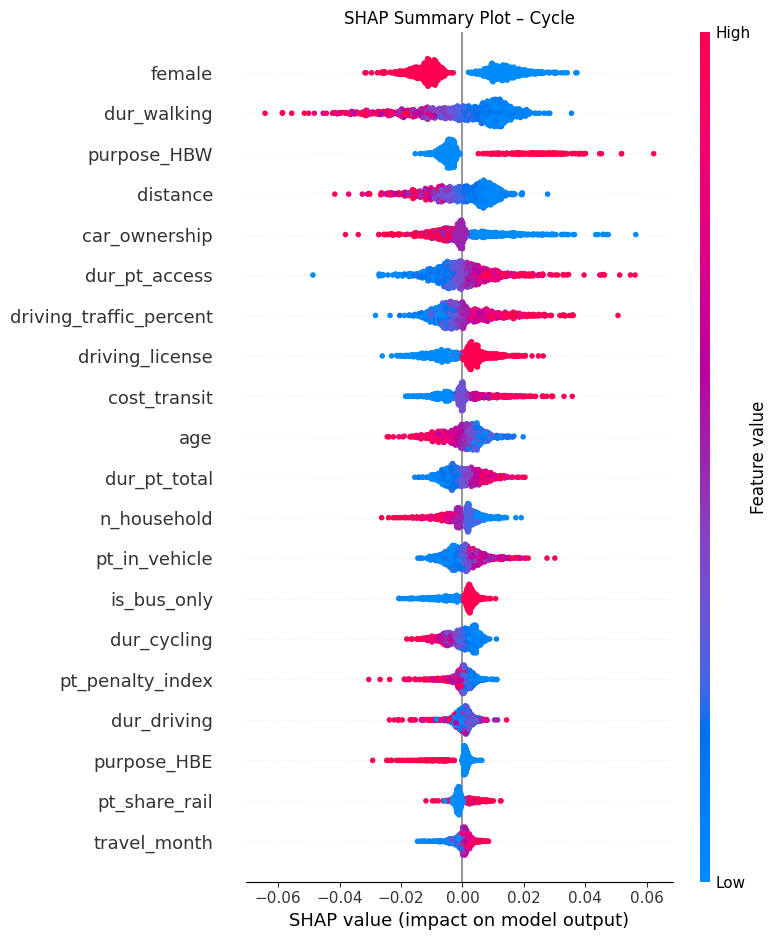

C:\Users\crist\AppData\Local\Temp\ipykernel_20856\206974303.py:8: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


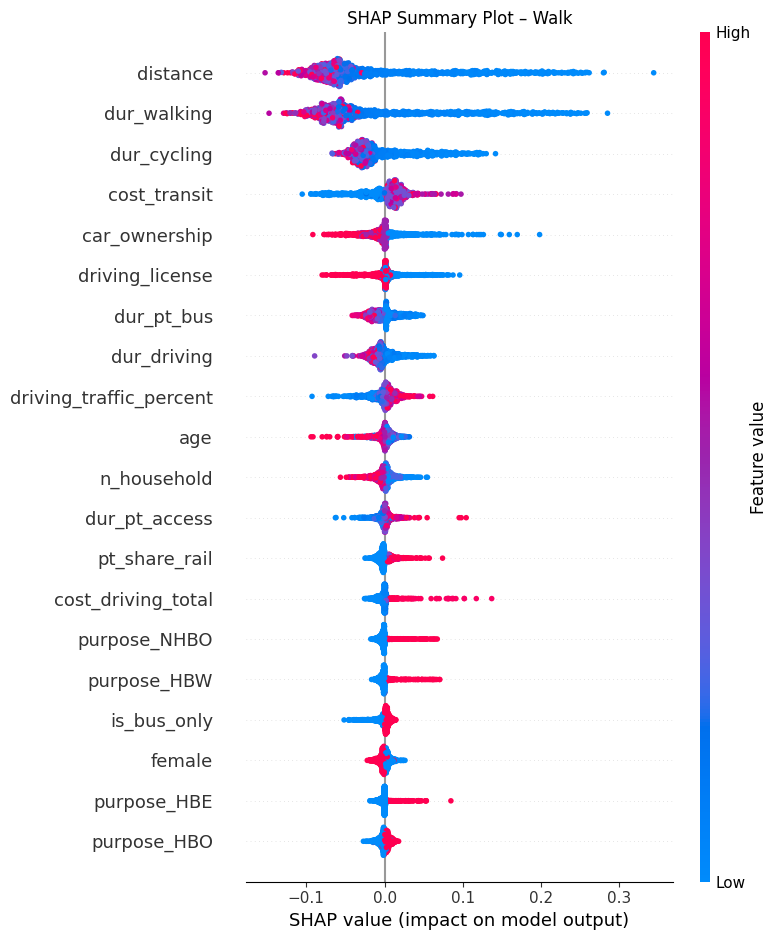

In [ ]:
target_names = ['PT', 'Drive', 'Cycle', 'Walk']
# Get feature names (excluding 'travel_mode' which is the target)
feature_names = selected_data.drop(['travel_mode'], axis=1).columns
n_samples, n_features, n_classes = shap_values.shape

for i, class_name in enumerate(target_names):   # e.g. ["PT", "Drive", "Cycle", "Walk"]
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[:, :, i],          # SHAP values for class i
        X_test_sample,               # corresponding input samples
        feature_names=feature_names,
        show=False
    )
    plt.title(f"SHAP Summary Plot – {class_name}")
    plt.tight_layout()
    plt.show()


C:\Users\crist\AppData\Local\Temp\ipykernel_19024\2733315072.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_scaled[:500], feature_names=feature_names, plot_type="bar", show=False)


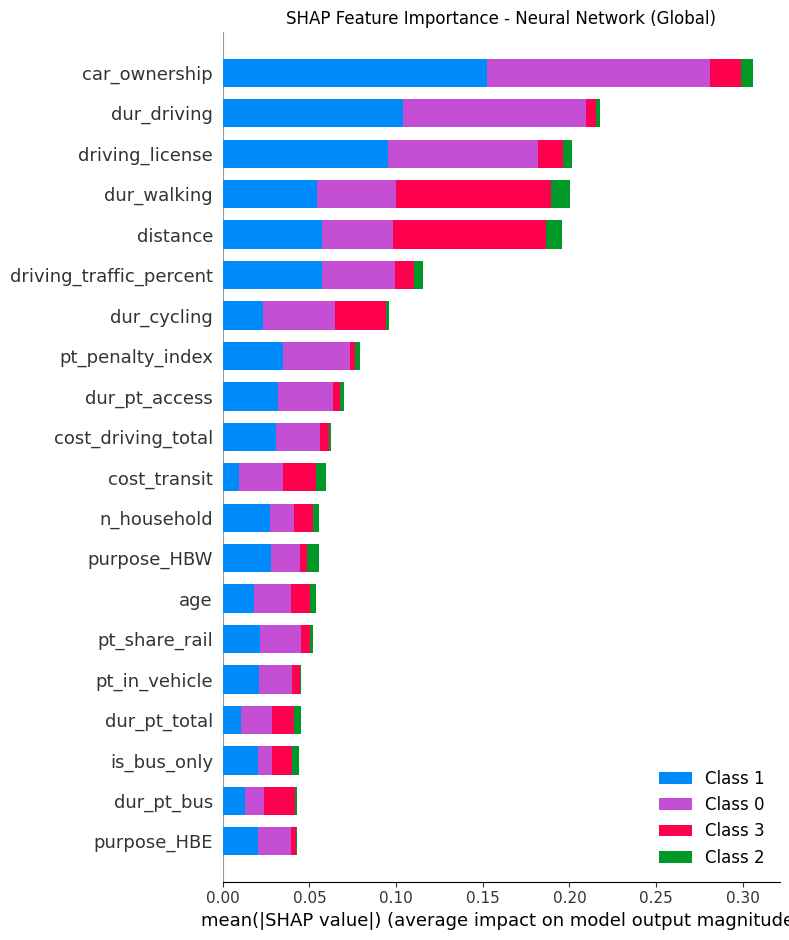


Local SHAP explanation for the first prediction:
Actual class: drive
Predicted class: pt


In [ ]:
# Global SHAP Bar Plot (Mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_scaled[:500], feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - Neural Network (Global)")
plt.tight_layout()
plt.show()

# Local explanation for a single instance (first sample)
print("\nLocal SHAP explanation for the first prediction:")
print(f"Actual class: {target_names[y_test[0]]}")
print(f"Predicted class: {target_names[np.argmax(model.predict(X_test_scaled[0:1], verbose=0)[0])]}")


## 15. Partial Dependence Plots

Visualize how individual features affect the probability of each transport mode choice while holding other features constant.

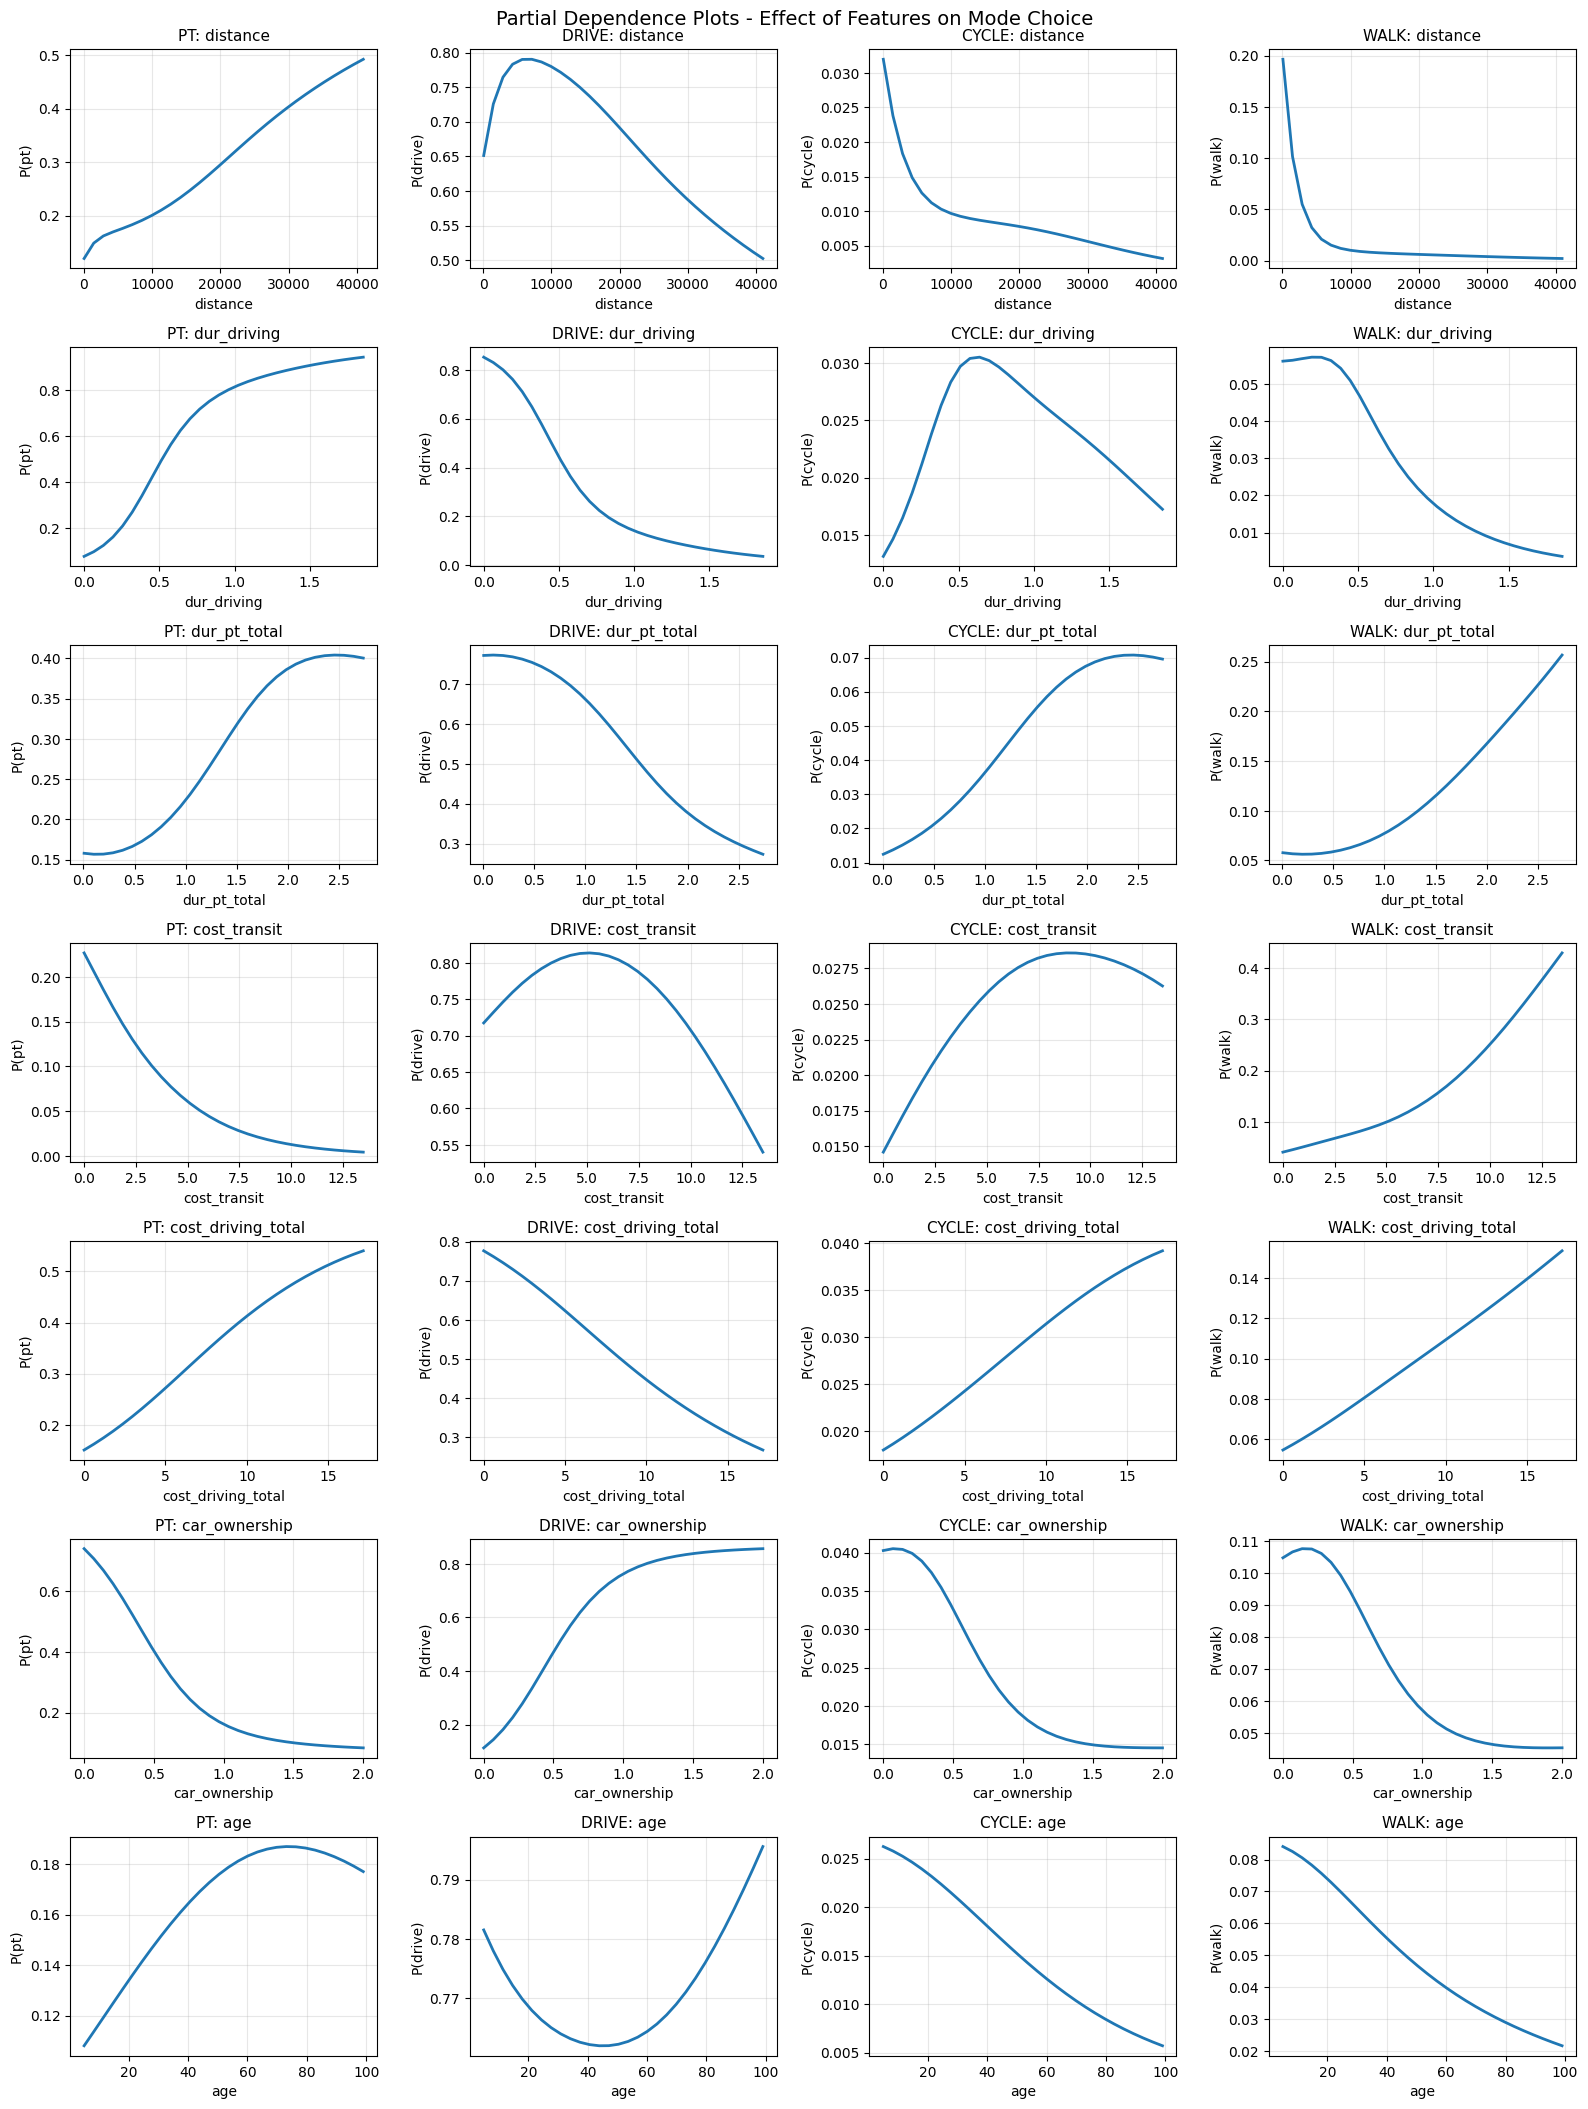

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Partial Dependence Plots for key features

# Select key features to analyze
key_features = ['distance', 'dur_driving', 'dur_pt_total', 'cost_transit', 
                'cost_driving_total', 'car_ownership', 'age']

# Get feature indices
feature_indices = [list(feature_names).index(f) for f in key_features]

# For each key feature, create partial dependence plot
fig, axes = plt.subplots(len(key_features), 4, figsize=(16, 3*len(key_features)))

for row, (feature, feature_idx) in enumerate(zip(key_features, feature_indices)):
    # Get feature statistics from training data
    feature_mean = X_train_scaled[:, feature_idx].mean()
    feature_std = X_train_scaled[:, feature_idx].std()
    
    # Create grid of values for this feature (in scaled space)
    grid_values = np.linspace(
        X_train_scaled[:, feature_idx].min(),
        X_train_scaled[:, feature_idx].max(),
        30
    )
    
    # Convert back to original scale for x-axis labels
    feature_col_idx = list(selected_data.drop(['travel_mode'], axis=1).columns).index(feature)
    original_mean = X_train[:, feature_col_idx].mean()
    original_std = X_train[:, feature_col_idx].std()
    grid_values_original = grid_values * original_std + original_mean
    
    # Create base sample (median of all features)
    base_sample = np.median(X_test_scaled, axis=0).reshape(1, -1)
    
    # Store predictions for each value
    predictions_grid = []
    
    for val in grid_values:
        # Create a copy of base sample
        sample = base_sample.copy()
        sample[0, feature_idx] = val
        
        # Predict probabilities
        pred = model.predict(sample, verbose=0)[0]
        predictions_grid.append(pred)
    
    predictions_grid = np.array(predictions_grid)
    
    # Plot for each class
    for col, (class_idx, class_name) in enumerate(mode_labels.items()):
        ax = axes[row, col] if len(key_features) > 1 else axes[col]
        
        class_probs = predictions_grid[:, class_idx]
        ax.plot(grid_values_original, class_probs, linewidth=2)
        ax.set_xlabel(feature, fontsize=10)
        ax.set_ylabel(f'P({class_name})', fontsize=10)
        ax.set_title(f'{class_name.upper()}: {feature}', fontsize=11)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.suptitle('Partial Dependence Plots - Effect of Features on Mode Choice', 
             fontsize=14, y=1.002)
plt.show()